# Understanding high-resolution spectral line profiles

Version: 2 (Updated May 2025)

Supervisor: Jake Pember ([jake.pember@kuleuven.be](mailto:jake.pember@kuleuven.be))

One of the most important ways astronomers study the universe is through spectroscopy. By dispersing incoming light into a spectrum, we can reveal otherwise hidden properties of the object being observed, for instance its temperature, chemical composition, rotational velocity, or its relative speed along the observer’s line-of-sight. In order to do these things, we must look at spectral features—emission or absorption at particular wavelengths of light.

In order to understand what we see in a recorded spectrum, we need to use our knowledge of the physical processes that cause the features, and we also need to understand the imprint that our scientific instrumentation leaves on the measurements themselves.

In this project, you will analyse part of an astronomical spectrum by fitting a theoretical function to a spectral absorption feature; determining the quality of the fit; and, by comparing the results between several different functions, determine which describes the measured data best.

<!-- <img src="./spectral-line-fitting.png" width="640"/> -->


---

In this project we will be working with a spectrum from `HERMES`, a high-resolution spectrograph at the Institute of Astronomy's Mercator Observatory on La Palma, in the Canary Islands. This instrument is coupled to the telescope by optical fibre, and uses both an 'Echelle grating' and a prism to doubly-disperse the collected light into a 2D spectral format. The more that light is dispersed, the higher the 'spectral resolution'. At 'high' spectral resolution (R >= 30,000), an instrument can resolve many features in the spectrum of a star, each one corresponding to a single energy-level change in a particular type of atom that is present in the star.

Here, we will look at one spectral line in particular: Hydrogen alpha. Because hydrogen is very abundant, hydrogen lines are typically some of the most significant features in stellar spectra, and were the first to be observed in early spectrometers. In fact the stellar spectral classification system (OBAFGKM spectral types) was originally created based on the appearance of the hydrogen lines in the spectra of these stars. The hydrogen atom is simple, with only a handful of energy levels that its single electron can take. For this reason the atom itself is well-studied through theory and modelling, and this provides us with a first handle to connect atomic theory with observations in astronomy.

We will use this Python notebook to go through the steps required to analyse a single spectral line. First, we need to load in data from an external file in a way that we can work with in Python, do some first analysis and clean-up of the data, select the region (single line) that we want to look at in more detail, and attempt to fit the spectral line with model functions, determine which provides the best fit, and understand the implications of this in terms of physics of the star, and impacts from elsewhere.

## Part 1: Handling Data

#### Connect this notebook to Google Drive

In [4]:
#from google.colab import drive
#drive.mount("/content/drive", force_remount=False)

Fill in (or from the directory tree on the left: 'Copy path...') the directory in which you have saved the data:

In [5]:
# Full path, eg. "/content/drive/MyDrive/Colab Notebooks/spectral_lines/data/"
DATA_DIR = "./data/"

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

#### Importing Python packages

* `fits` (from `astropy.io`) will be used to load images in FITS format, a standard format for scientific images in the field of astronomy
* `numpy` is a very commonly used library for numeric computations
* `pyplot` (from `matplotlib`) is a plotting library, allowing us to display graphs or images

In [7]:
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt

First, we will load the raw data straight out of the spectrograph, stored on disk as a FITS file.

In [8]:
filename = "01102367_HRF_OBJ.fits"

raw = fits.open(DATA_DIR + filename)

Now the variable `raw` stores all the information in the FITS file. FITS files are commonly used in astronomy in particular, and can store a wide variety of types of data, as well as metadata. You can use `.info()` to see what is inside the loaded file

In [9]:
raw.info()

Filename: ./data/01102367_HRF_OBJ.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     113   (2148, 4672)   int16 (rescales to uint16)   


In fact, `raw` itself is a list of HDU objects (Header/Data Units); here only a single one at index 0, but some FITS files will have several HDUs inside. We can select index 0 and read the `.header` to see all the metadata stored alongside the `.data`:

In [10]:
raw[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2148                                                  
NAXIS2  =                 4672                                                  
EXTEND  =                    F                                                  
ORIGIN  = 'Instituut voor Sterrenkunde, KU Leuven' / Institution                
OBSERVAT= 'LaPalma '           / Observatory name                               
TELESCOP= 'Mercator'           / Telescope name                                 
OBSGEO-X=         5327306.5552 / Cartesian X [meters] GRS80                     
OBSGEO-Y=        -1718448.6952 / Cartesian Y [meters] GRS80                     
OBSGEO-Z=         3051947.7715 / Cartesian Z [meters] GRS80                     
OBSERVER= 'Jake Pember'     

And likewise access the `.data` itself, which here is a 2D array of values:

In [11]:
raw[0].data

array([[2180, 2171,    0, ..., 2178, 2175, 2169],
       [2167, 2176, 2159, ..., 2175, 2172, 2173],
       [2169, 2165, 2165, ..., 2172, 2175, 2172],
       ...,
       [2168, 2171, 2150, ..., 2173, 2181, 2169],
       [2174, 2172, 2154, ..., 2174, 2165, 2177],
       [2172, 2178, 2155, ..., 2174, 2175, 2173]],
      shape=(4672, 2148), dtype=uint16)

In fact, it is an image taken on a CCD image sensor, and shows the full 2D spectral format, with the spectrum spanning more than the full range of visible light.

Alter the `vmin` and `vmax` values to change the brightness and contrast of the image until you can see the details.

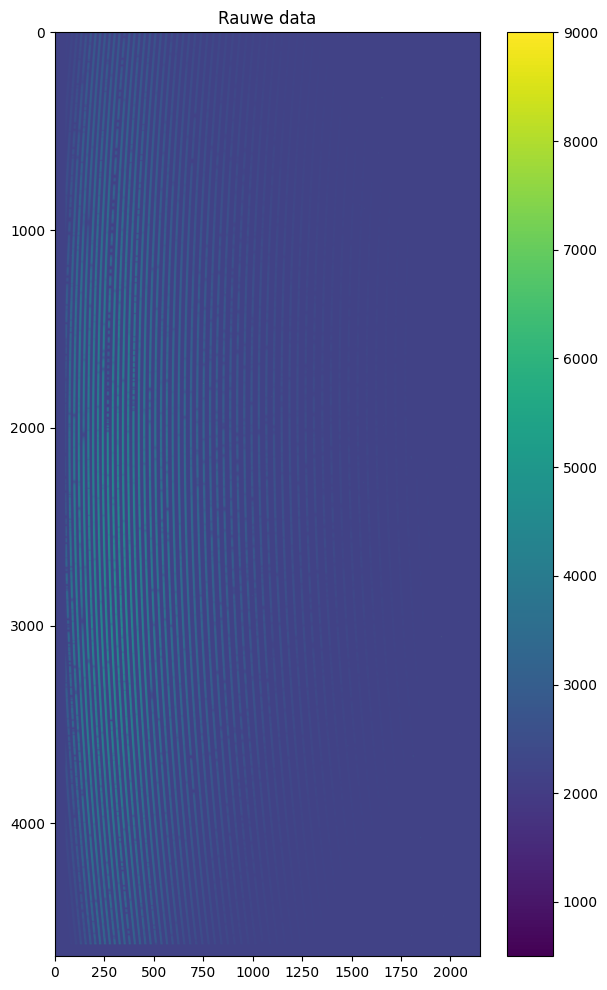

In [12]:
plt.figure(figsize=(7, 12))

plt.imshow(
    raw[0].data,
    vmin=500,
    vmax=9000,
    )

plt.title("Rauwe data")
plt.colorbar()
plt.savefig("raw.png")

Hopefully you can see that this image is dense with information: the vertical (curved) stripes that you see are individual "spectral orders", each containing part of the star's spectrum spanning a small wavelength range. Even at this scale, you can see many dark (absorption) features in the spectrum. You can also see large-scale gradients in brightness. These come from both the star and the instrument itself.

The HERMES data reduction pipeline provides a number of different data products. Rather than starting from the above raw image, we will instead load in data that already has each of these spectral orders "extracted" for us into 1D arrays.

In [13]:
filename = "01102367_HRF_OBJ_extVar.fits"

extracted = fits.open(DATA_DIR + filename)

Use the `plt.imshow()` function to display the data loaded into `extracted`, as above.

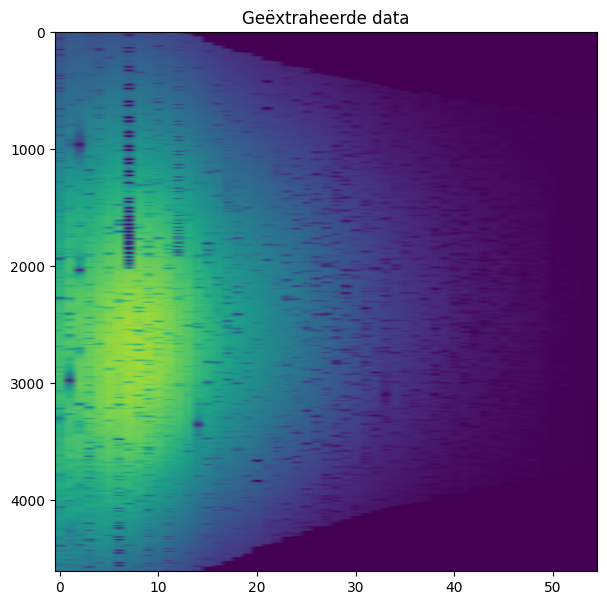

In [14]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(extracted[0].data, aspect="auto")
plt.title("Geëxtraheerde data")
plt.savefig("extracted.png")

Here we see the same data after some processing. We can still view it as an image because it is a 2D array, with each column containing the data from a single spectral order after it has been extracted. We can access each one by indexing this data array appropriately. Because of the structure of the data, a _slice_ like `[:, 10]` will give all pixel values (`:` in the first axis) for a spectral order at a given index (`10` in the second axis).

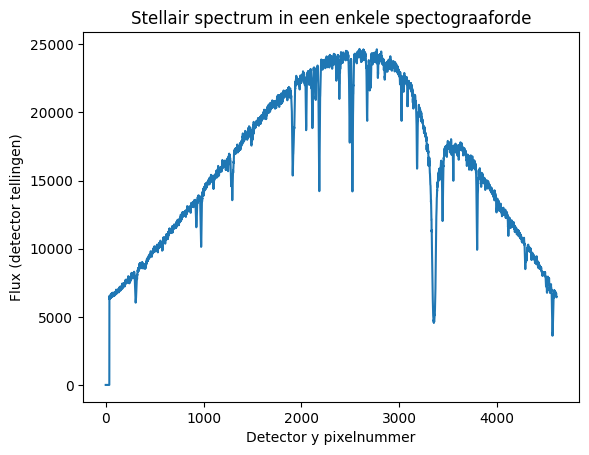

In [15]:
plt.plot(extracted[0].data[:, 14])

plt.title("Stellair spectrum in een enkele spectograaforde")
plt.xlabel("Detector y pixelnummer")
plt.ylabel("Flux (detector tellingen)")
plt.savefig("single_order.png")

The above plot shows several features, but the most obvious thing is the large-scale curve, peaking in the centre and with the signal dropping either side of this. This is known as the 'blaze function', and is an artefact produced by the instrument. If you change the order index number, you will see that every spectral order is modulated by the same function shape. In order to start to correct for this, we can use 'flat field' data - the spectrum we measure when the input is spectrally "flat" - with no features or slope:

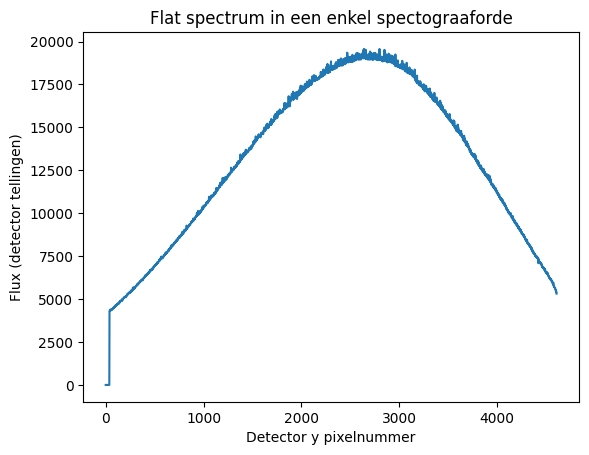

In [41]:
filename = "01102308_HRF_FF_extVar.fits"

flat_field = fits.open(DATA_DIR + filename)
plt.plot(flat_field[0].data[:,14])

plt.title("Flat spectrum in een enkel spectograaforde")
plt.xlabel("Detector y pixelnummer")
plt.ylabel("Flux (detector tellingen)")
plt.savefig("Flat spectrum in a single sepctograph order")

So far we have been looking at data representing brightness as a function of position on the detector (pixel number). What we would much prefer is knowing which wavelengths of light these pixels correspond to. _Wavelength calibration_ is a very important part of dealing with data from spectrographs of all kinds, and can be very time-conuming to implement. Here we are lucky, because the `HERMES` data reduction pipeline also provides us with the corresponding wavelength scale for each spectral order:

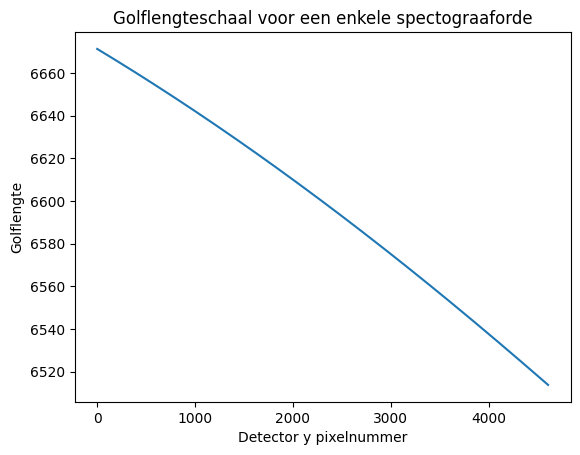

In [42]:
filename = "01102397_HRF_TH_ext_wavelengthScale.fits"

wavelength_scale = fits.open(DATA_DIR + filename)
plt.plot(wavelength_scale[0].data[14])

plt.title("Golflengteschaal voor een enkele spectograaforde")
plt.xlabel("Detector y pixelnummer")
plt.ylabel("Golflengte")
plt.savefig("Golflengte_kalibratie")

Now we need to identify the correct spectral order, the one containing the Hydrogen-alpha line. Look up the wavelength of this spectral line, and then complete the code below. By changing the `order_index` variable, you can step through the individual spectral orders, each covering a slightly different wavelength range in the spectrograph. Take note of which wavelength range you are looking at, and locate Hydrogen-alpha. If you see any other features that look interesting, see if you can identify them by looking at their wavelength and searching known spectral lines online. Very strong lines may be identifiable here: [Fraunhofer lines](https://en.wikipedia.org/wiki/Fraunhofer_lines).

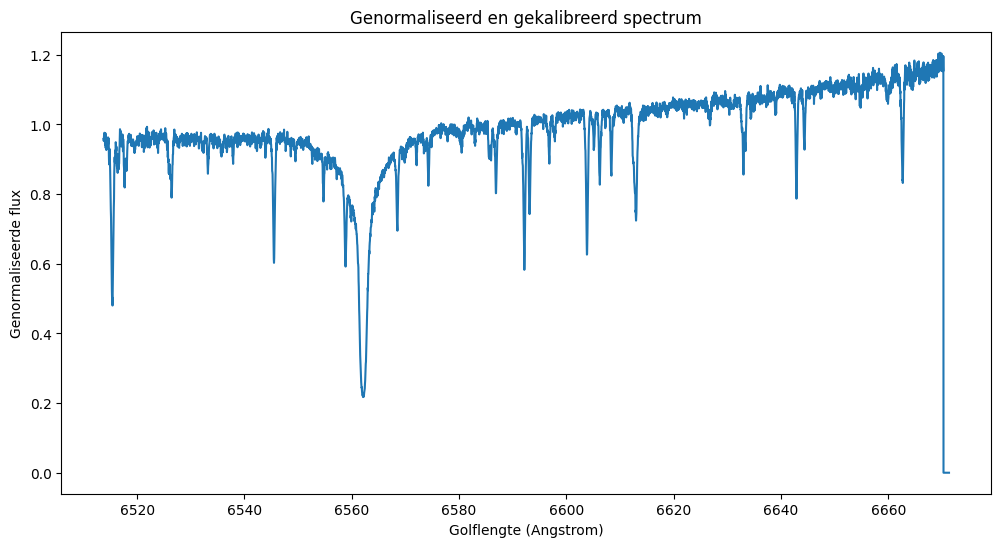

In [43]:
order_index = 14

# First get the relevant data from each of the files we have loaded
wavelengths = wavelength_scale[0].data[order_index]
flat_flux = flat_field[0].data[:, order_index]
stellar_flux = extracted[0].data[:, order_index]

# Now correct the stellar spectrum with the flat spectrum
blaze_corrected = stellar_flux / (flat_flux + 1e-10) # Here I added a small value to the denominator to avoid dividing by zero
normalised_corrected_flux = blaze_corrected / np.median(blaze_corrected)

# Now plot the corrected spectrum as a function of wavelength
plt.figure(figsize=(12, 6))
plt.plot(wavelengths, normalised_corrected_flux)

plt.title(f"Genormaliseerd en gekalibreerd spectrum")
plt.xlabel("Golflengte (Angstrom)")
plt.ylabel("Genormaliseerde flux")
plt.savefig("Genormaliseerd_gekalibreerd_spectrum")


This is our first look at the data we want to work with - an array of normalised fluxes containing Hydrogen-alpha (and several other spectral lines). These data will form the basis for the next parts of this project: estimating the noise in the spectrum, and fitting the Hydrogen-alpha spectral line with one or more model functions to determine which provides the best fit to the data.

## Part 2: Cleaning up the Data, Estimating the Noise in the Spectrum

#### Importing Python packages

In addition to the packages above imported for Part 1, we will also use:

* `savgol_filter` (from `scipy.signal`), an implementation of the Savitzky-Golay smoothing filter

In [19]:
from scipy.signal import savgol_filter

First, we can do better than the last step in Part 1! When we divide by a reference "flat" spectrum, we are also dividing by any noise present in that spectrum. Instead, we should first fit the flat spectrum with a nice, smooth (noiseless) function, and then divide our data by that.

In [20]:
# We will use the spectral order containing the hydrogen-alpha line
Ha_order_index = 14

wavelengths = wavelength_scale[0].data[Ha_order_index]
flat_flux = flat_field[0].data[:, Ha_order_index]
stellar_flux = extracted[0].data[:, Ha_order_index]

***Your turn to code!***

Complete the following code cell with the required lines of code. First, we want to calculate the wavelength span of the spectral order that we are looking at, and then offset the full wavelength array by some value so that zero is in its centre.

Then, select an appropriate polynomial degree with the `deg` argument of `np.polyfit`. You can judge how well the polynomial is fitting the data by running the following code cell, which will plot the results.

In [21]:
# The difference between the maximum and minimum wavelengths
wavelength_span = np.max(wavelengths) - np.min(wavelengths)

# Center the wavelength range about zero
wavelengths_centred = wavelengths - np.min(wavelengths) - wavelength_span / 2

# Divide flux array by its maximum value
normalised_flux = flat_flux / np.max(flat_flux)

# Mask out any parts of the order with zero data
nonzero_mask = normalised_flux != 0

# Fit a polynomial to the data:
fit = np.polyfit(wavelengths_centred[nonzero_mask], normalised_flux[nonzero_mask], deg=4)

# Create a callable function with the polynomial fit
function = np.poly1d(fit)

You can judge how well you are fitting the data by plotting it:

Text(0, 0.5, 'Normalised Flux')

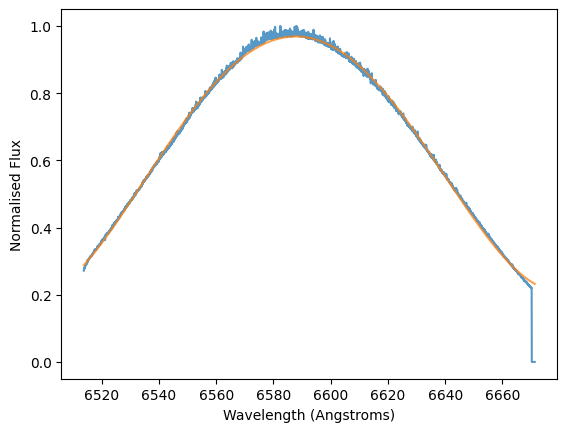

In [22]:
plt.plot(wavelengths, flat_flux / np.max(flat_flux), alpha=0.75)
plt.plot(wavelengths, function(wavelengths_centred), alpha=0.75)

plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Normalised Flux")

Once you are happy with your fit to the 'flat' spectrum, we can also apply this to the stellar spectrum.

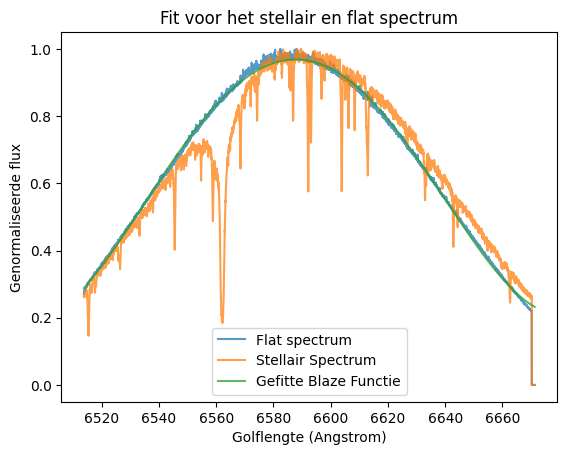

In [23]:
plt.plot(wavelengths, flat_flux / np.max(flat_flux), alpha=0.75, label="Flat spectrum")
plt.plot(wavelengths, stellar_flux / np.max(stellar_flux), alpha=0.75, label="Stellair Spectrum")
plt.plot(wavelengths, function(wavelengths_centred), alpha=0.75, label="Gefitte Blaze Functie")
plt.legend()

plt.title("Fit voor het stellair en flat spectrum")
plt.xlabel("Golflengte (Angstrom)")
plt.ylabel("Genormaliseerde flux")
plt.savefig("Flat_stellar_spectrum_met_fit")

Text(0, 0.5, 'Normalised Flux')

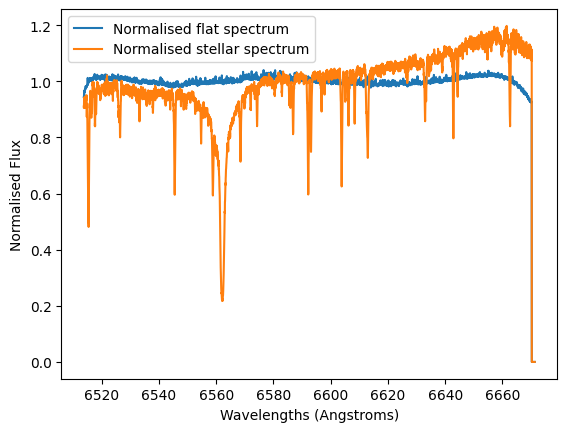

In [24]:
plt.plot(wavelengths, (flat_flux / np.max(flat_flux)) / function(wavelengths_centred), label="Normalised flat spectrum")
plt.plot(wavelengths, (stellar_flux / np.max(stellar_flux)) / function(wavelengths_centred), label="Normalised stellar spectrum")
plt.legend()

plt.xlabel("Wavelengths (Angstroms)")
plt.ylabel("Normalised Flux")

With a perfect fit, the continuum of our spectrum will lie at a value of `1.0`. To achieve this can take quite a lot more work, involving smoothing kernels and modelling the blaze function starting with its known functional form, a sinc-squared function centred at a particular wavelength. Our polynomial fit here may not be perfect, but it is good enough to continue for the project.

We can store this normalised data into a new variable.

In [25]:
Halpha_flux = (stellar_flux / np.max(stellar_flux)) / function(wavelengths_centred)

In order to estimate the random scatter of noise in our spectrum, we will use a smoothing filter to generate "noise free" data while keeping all of the spectral features in tact. We can then divide out this smoothed signal and be left with a representative scatter of noise from the data.

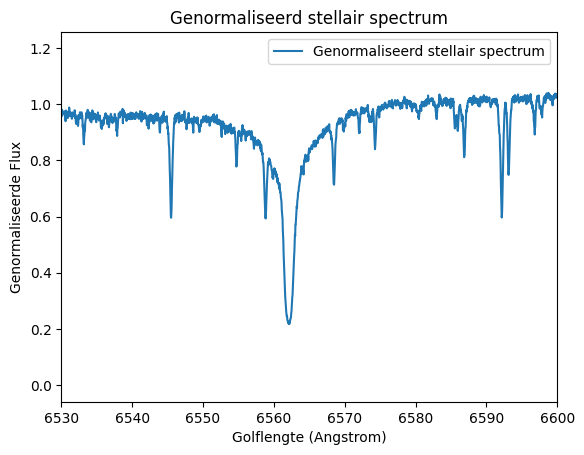

In [26]:
plt.plot(wavelengths, Halpha_flux, label="Genormaliseerd stellair spectrum")
plt.legend()
plt.xlim(6530, 6600)

plt.title("Genormaliseerd stellair spectrum")
plt.xlabel("Golflengte (Angstrom)")
plt.ylabel("Genormaliseerde Flux")
plt.savefig("Genormaliseerd_stellair_spectrum")

Apply the `savgol_filter` to this stellar spectrum to create a smoothed version that still captures the spectral features, but removes much of the random scatter. Look up the [documentation for `savgol_filter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html) and experiment with different values for `window_length` and `polyorder` until you are happy with the result.

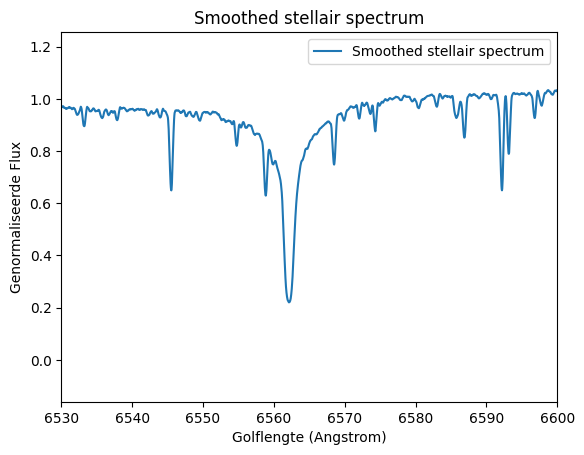

In [27]:
smoothed = savgol_filter(Halpha_flux, window_length=30, polyorder=4)

plt.plot(wavelengths, smoothed, label="Smoothed stellair spectrum")
plt.legend()
plt.xlim(6530, 6600)
plt.title("Smoothed stellair spectrum")
plt.xlabel("Golflengte (Angstrom)")
plt.ylabel("Genormaliseerde Flux")
plt.savefig("Smoothed_stellair_spectrum")

Create a `residuals` array by subtracting off your new smoothed data from the original data array.

Estimate the noise using a standard deviation. You may not want to use the full array for this, but select only part of it using a slice.

Because we are working with normalised data, with the 'signal' being (roughly) at a value of 1.0, the implied signal-to-noise ratio (SNR) of the data is just the inverse of the standard deviation of the noise.

Noise estimate: 0.0118
Estimated Signal-to-Noise ratio: 84.9928 per pixel


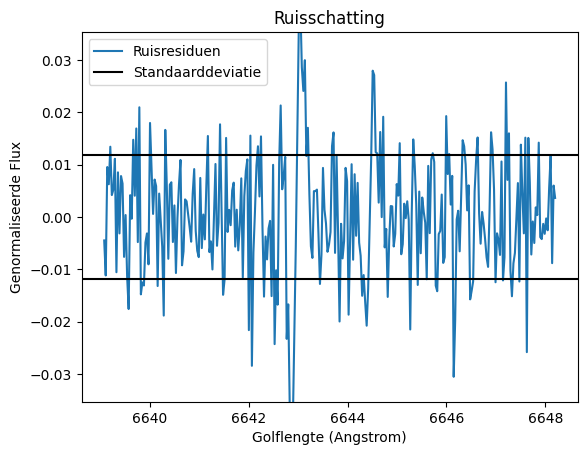

In [28]:
#[800, 1100] werkt wel
#[100,200] ook
#150, 250
#2000, 2100
#100,600
noise_region_start = 800
noise_region_end = 1100

residuals = Halpha_flux - smoothed

standard_deviation = np.std(residuals[noise_region_start:noise_region_end])

# Use the standard deviation to indicate the noise level and implied S/N
print(f"Noise estimate: {standard_deviation:.4f}")
print(f"Estimated Signal-to-Noise ratio: {1 / standard_deviation:.4f} per pixel")



plt.plot(wavelengths[noise_region_start:noise_region_end], residuals[noise_region_start:noise_region_end], label="Ruisresiduen")

plt.axhline(y = -1 * standard_deviation, color="k")
plt.axhline(y = standard_deviation, color="k", label="Standaarddeviatie")

plt.legend()

#plt.xlim(6600, 6670)
plt.ylim(-3 * standard_deviation, 3 * standard_deviation)

plt.title("Ruisschatting")
plt.xlabel("Golflengte (Angstrom)")
plt.ylabel("Genormaliseerde Flux")
plt.savefig("Ruisschatting")

## Part 3: Fitting the Hydrogen-alpha Absorption Line

#### Importing Python packages

In addition to the packages above imported for Part 1, we will also use:

* `voigt_profile` (from `scipy.special`), an implementation of the Voigt function, a convolution between a Gaussian and a Lorentzian function
* `curve_fit` (from `scipy.optimize`) to iteratively adjust parameters of a function to fit our measured data

In [29]:
from scipy.special import voigt_profile
from scipy.optimize import curve_fit

First we define the Voigt function. Here a "wrapper" function is made around the exitsting `voigt_profile` from SciPy. The wrapper provides an additional two arguments: `scale` and `x0`.

In [30]:
def voigt(x, scale, x0, alpha, gamma):
  # Input parameters:
  # x = Position argument for the profile (e.g. wavelength)
  # scale = Multiplicative scaling of the (normliased) profile
  # 0 = Centre of the profile, in same units as x
  # alpha = Broadening (half-width at half maximum) of the Gaussian component
  # gamma = Broadening (half-width at half maximum) of the Lorentzian component

  x = x - x0  # Centre the profile on wavelength x0
  return 1 - scale * voigt_profile(x, alpha, gamma)

In [44]:
def asymmetric_voigt(x, scale, x0, alpha_L, alpha_R, gamma_L, gamma_R):
    alpha = np.where(x < x0, alpha_L, alpha_R)
    gamma = np.where(x < x0, gamma_L, gamma_R)
    return voigt(x, scale, x0, alpha, gamma)


Asymmetrische Voigt fit:
  scale = 3.05 ± 0.0418
  x0 = 6.56e+03 ± 0.0187
  alpha_L = 2.67e-16 ± 1.47e+06
  alpha_R = 1.98e-08 ± 1.01e+06
  gamma_L = 1.26 ± 0.0336
  gamma_R = 1.32 ± 0.0315


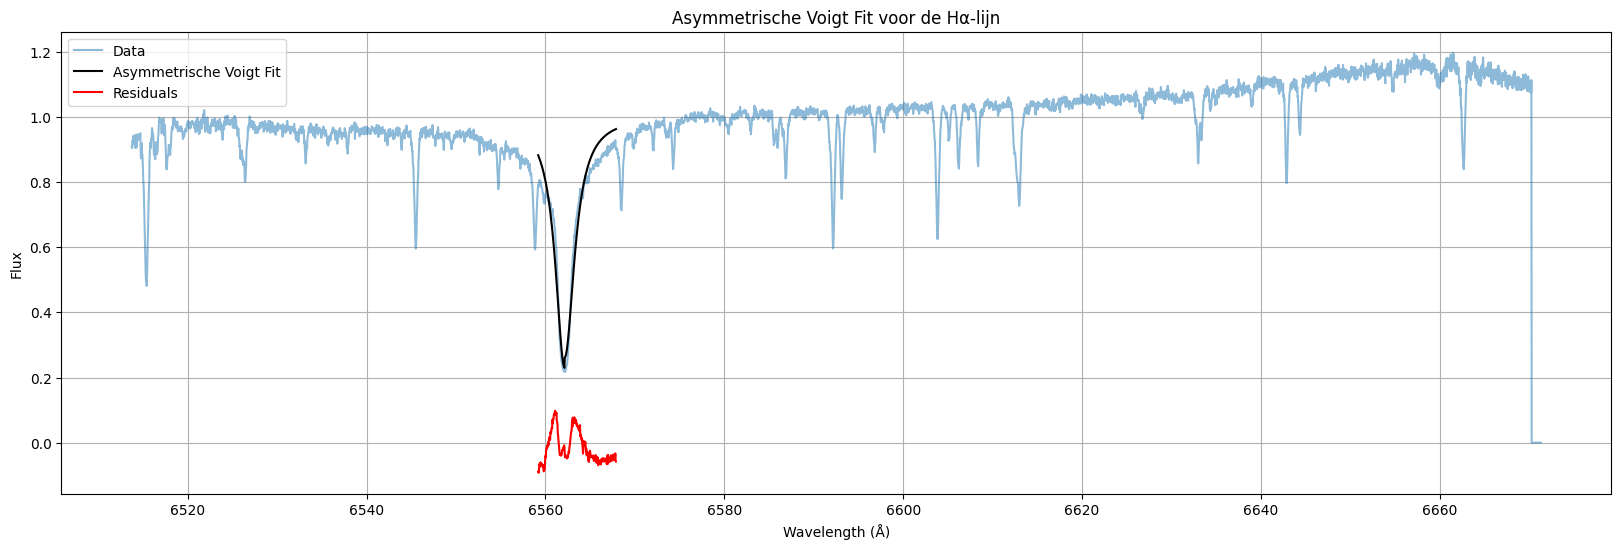

In [65]:
sliceb = 3198
slicee = 3434
xdata = wavelengths[sliceb:slicee]
ydata = Halpha_flux[sliceb:slicee]

# Fitparameters: scale, x0, alpha_L, alpha_R, gamma_L, gamma_R
p0 = [2, 6563, 1, 1, 1, 1]
bounds = ([0, 6550, 0, 0, 0, 0], [10, 6576, 5, 5, 5, 5])

# Fit uitvoeren
popt, pcov = curve_fit(asymmetric_voigt, xdata, ydata, p0=p0, bounds=bounds)
perr = np.sqrt(np.diag(pcov))

# Resultaten printen
scale, x0, alpha_L, alpha_R, gamma_L, gamma_R = popt
dx0 = perr[1]
print("Asymmetrische Voigt fit:")
print(f"  scale = {scale:.3g} ± {perr[0]:.3g}")
print(f"  x0 = {x0:.3g} ± {perr[1]:.3g}")
print(f"  alpha_L = {alpha_L:.3g} ± {perr[2]:.3g}")
print(f"  alpha_R = {alpha_R:.3g} ± {perr[3]:.3g}")
print(f"  gamma_L = {gamma_L:.3g} ± {perr[4]:.3g}")
print(f"  gamma_R = {gamma_R:.3g} ± {perr[5]:.3g}")

# Plot
plt.figure(figsize=(20, 6))
plt.plot(wavelengths, Halpha_flux, label="Data", alpha=0.5)
plt.plot(xdata, asymmetric_voigt(xdata, *popt), label="Asymmetrische Voigt Fit", color='black')
plt.plot(xdata, ydata - asymmetric_voigt(xdata, *popt), label="Residuals", color='red')
plt.legend()
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.title("Asymmetrische Voigt Fit voor de Hα-lijn")
plt.grid(True)
plt.show()


In [33]:
def voigt_with_linear(x, scale, x0, alpha, gamma, a, b):
    return voigt(x, scale, x0, alpha, gamma) + a*x + b

Voigt + linear fit:
  scale = 1.56 ± 0.05
  x0 = 6.56e+03 ± 0.00577
  alpha = 0.394 ± 0.0361
  gamma = 0.579 ± 0.0468
  a = 0.0102 ± 0.000749
  b = -67.2 ± 4.92
Full Width Half Maximum (FWHM): f_V = 1.5574429193279395


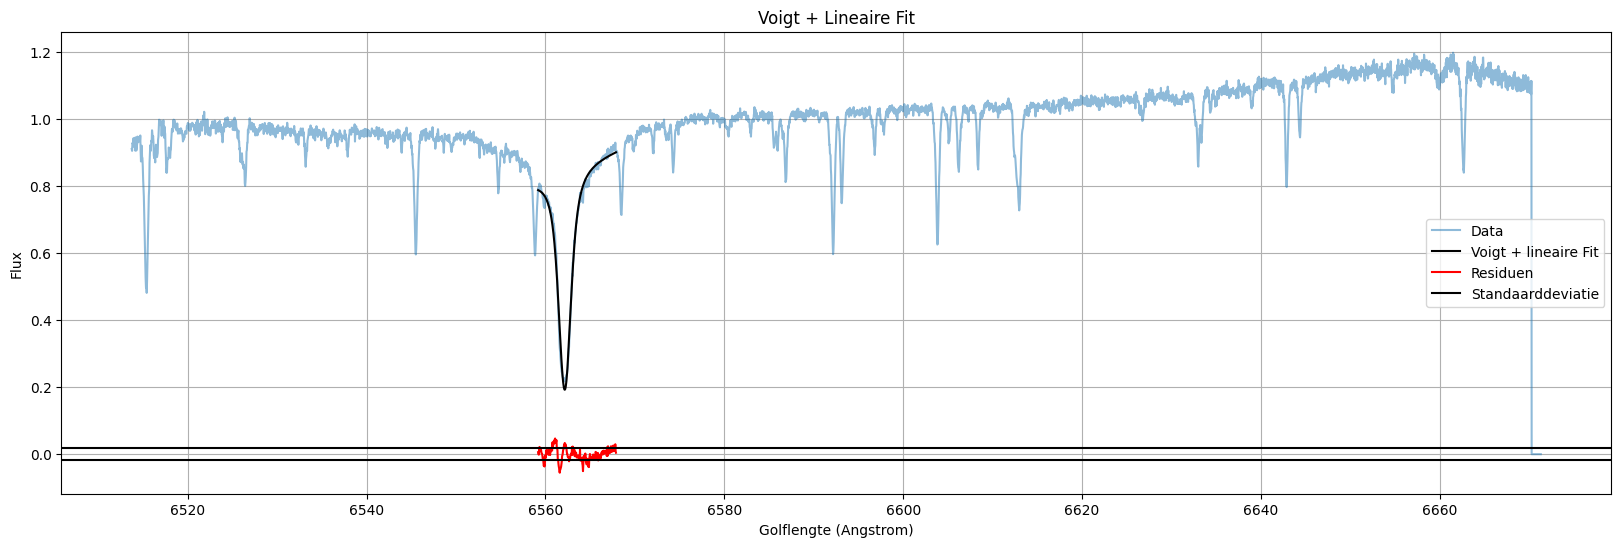

In [68]:

p0 = [10, 6563, 0.5, 1, 0, 1]
bounds = ([0, 6550, 0, 0, -np.inf, -np.inf], [10, 6576, 5, 5, np.inf, np.inf])

popt, pcov = curve_fit(voigt_with_linear, xdata, ydata, p0=p0, bounds=bounds)
perr = np.sqrt(np.diag(pcov))

# Resultaten printen
scale, x0, alpha, gamma, a, b = popt
dx0 = perr[1]
print(f"Voigt + linear fit:\n  scale = {scale:.3g} ± {perr[0]:.3g}")
print(f"  x0 = {x0:.3g} ± {perr[1]:.3g}")
print(f"  alpha = {alpha:.3g} ± {perr[2]:.3g}")
print(f"  gamma = {gamma:.3g} ± {perr[3]:.3g}")
print(f"  a = {a:.3g} ± {perr[4]:.3g}")
print(f"  b = {b:.3g} ± {perr[5]:.3g}")
#print(f"  c = {c:.3g} ± {perr[6]:.3g}")

standard_deviation = np.std(ydata-voigt_with_linear(xdata, *popt))

f_G = 2*alpha
f_L = 2*gamma
f_V = f_L/2 + np.sqrt(f_L**2 / 4 + f_G**2)
print(f"Full Width Half Maximum (FWHM): f_V = {f_V}")


# Plot
plt.figure(figsize=(20, 6))
plt.plot(wavelengths, Halpha_flux, label="Data", alpha=0.5)
plt.plot(xdata, voigt_with_linear(xdata, *popt), label="Voigt + lineaire Fit", color='black')
plt.plot(xdata, ydata - voigt_with_linear(xdata, *popt), label="Residuen", color='red')

plt.axhline(y = -1 * standard_deviation, color="k")
plt.axhline(y = standard_deviation, color="k", label="Standaarddeviatie")

plt.legend()
plt.xlabel("Golflengte (Angstrom)")
plt.ylabel("Flux")
plt.title("Voigt + Lineaire Fit")
plt.grid(True)
plt.savefig("Voigt_linear_fit.png")
plt.show()

x0_p = x0
dx0_p = dx0

In [35]:
def voigt_with_poly3(x, scale, x0_p, alpha, gamma, a, b, c, d):
    return voigt(x, scale, x0_p, alpha, gamma) + a*x**3 + b*x**2 + c*x + d

Voigt + linear fit:
  scale = 1.2 ± 0.034
  x0 = 6.56e+03 ± 0.0049
  alpha = 0.531 ± 0.0234
  gamma = 0.299 ± 0.0406
  a = 2.65e-06 ± 2.55e-11
  b = -0.0495 ± 3.68e-07
  c = 306 ± 0.00138
  d = -6.31e+05 ± 6.3e-07
Full Width Half Maximum (FWHM): f_V = 1.401338315980293


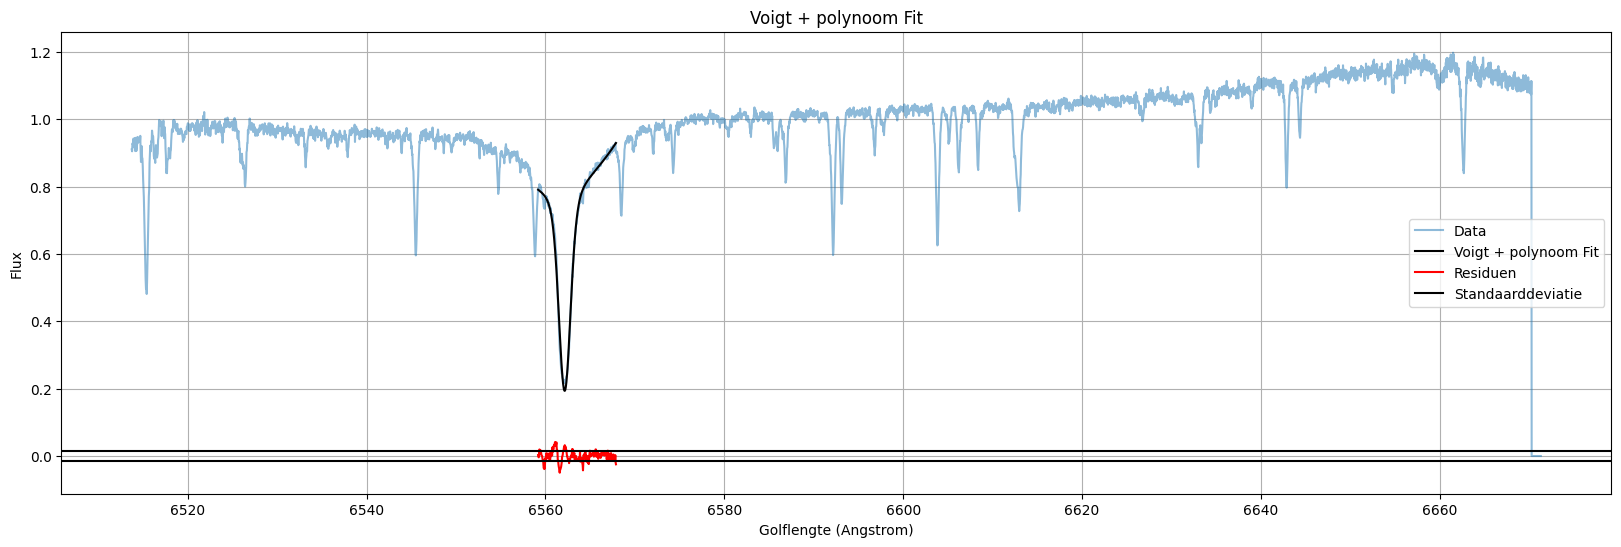

In [ ]:
p0 = [10, 6560, 0.5, 1, 0, 1, 1, 1]
bounds = ([0, 6550, 0, 0, -np.inf, -np.inf, -np.inf, -np.inf], [10, 6576, 5, 5, np.inf, np.inf, np.inf, np.inf])

popt, pcov = curve_fit(voigt_with_poly3, xdata, ydata, p0=p0, bounds=bounds)
perr = np.sqrt(np.diag(pcov))

# Resultaten printen
scale, x0_p, alpha, gamma, a, b, c, d = popt
dx0_p = perr[1]
print(f"Voigt + linear fit:\n  scale = {scale:.3g} ± {perr[0]:.3g}")
print(f"  x0 = {x0_p:.3g} ± {perr[1]:.3g}")
print(f"  alpha = {alpha:.3g} ± {perr[2]:.3g}")
print(f"  gamma = {gamma:.3g} ± {perr[3]:.3g}")
print(f"  a = {a:.3g} ± {perr[4]:.3g}")
print(f"  b = {b:.3g} ± {perr[5]:.3g}")
print(f"  c = {c:.3g} ± {perr[6]:.3g}")
print(f"  d = {d:.3g} ± {perr[7]:.3g}")
#print(f"  e = {e:.3g} ± {perr[8]:.3g}")

standard_deviation = np.std(ydata-voigt_with_poly3(xdata, *popt))

f_G = 2*alpha
f_L = 2*gamma
f_V = f_L/2 + np.sqrt(f_L**2 / 4 + f_G**2)
print(f"Full Width Half Maximum (FWHM): f_V = {f_V}")

# Plot
plt.figure(figsize=(20, 6))
plt.plot(wavelengths, Halpha_flux, label="Data", alpha=0.5)
plt.plot(xdata, voigt_with_poly3(xdata, *popt), label="Voigt + polynoom Fit", color='black')
plt.plot(xdata, ydata - voigt_with_poly3(xdata, *popt), label="Residuen", color='red')

plt.axhline(y = -1 * standard_deviation, color="k")
plt.axhline(y = standard_deviation, color="k", label="Standaarddeviatie")

plt.legend()
plt.xlabel("Golflengte (Angstrom)")
plt.ylabel("Flux")
plt.title("Voigt + polynoom Fit")
plt.grid(True)

plt.savefig("Voigt_polynomial_fit.png")
plt.show()

The above Voigt function gives a profile centred on a position, and of varying width driven by the 'alpha' and 'gamma' parameters. If gamma is the dominant term, the profile will be more Lorentzian. Conversely, if alpha is dominant, the profile is more Gaussian.

***Your turn to code!***

Make a plot using the above function that shows what happens when one term dominates over the other. Do this by plotting the function centred around zero, once with `gamma=1` and `alpha=` some small value (but not zero); and once (overplotting) with `alpha=1` and `gamma=` some small value, non-zero. Use the `label` keyword for each plotting call, and the `plt.legend()` command to accurately identify which line is Gaussian-dominated and which is Lorentzian-dominated. Note: you may have to try different `scale` values to match the peak height of the two curves!

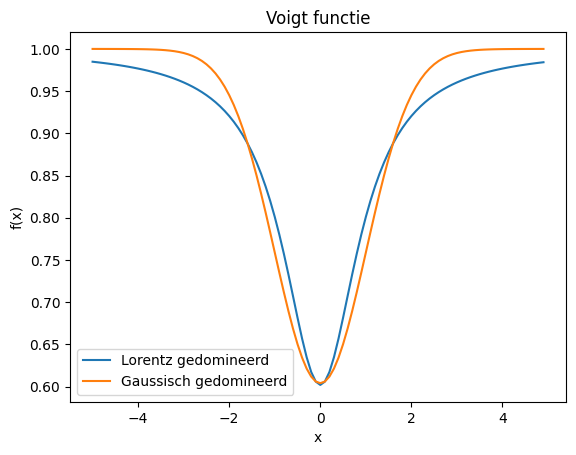

In [37]:
# First, generate some positions to evaluate the functoin on
x = np.arange(-5,5,0.1)

# Now make the plot
plt.plot(x, voigt(x, scale=1.25, x0=0, alpha=0.01, gamma=1), label="Lorentz gedomineerd")
plt.plot(x, voigt(x, scale=1, x0=0, alpha=1, gamma=0.01), label="Gaussisch gedomineerd")

plt.legend()
plt.title("Voigt functie")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.savefig("Voigt_dominance.png")

You now have everything you need to fit your H$\alpha$ line. To do this, you will use a general-purpose fitting routine, or 'optimiser', which will try to find the best combination of parameters that minimizes the difference between the model and your data. This is a form of non-linear least-squares fitting: 'non-linear' because the Voigt function is more complex than a simple linear combination; 'least-squares' because the sum of the squared difference between the model and data are minimized in the process.

The optimiser we will use is [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) which uses the [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares) routine.

The **input** parameters consist of:
*   The function name (this is your Voigt function)
*   The data arrays to be fitted by that function (your wavelength and flux vectors)
*   An array that defines the starting point in the parameter space (i.e. a first guess for the function to start optimising from)
*   Limits on the paramter values

The **outputs** of this routine are the best-fit parameters for the function, and a covariance matrix that contains an estimate of the parameter uncertainties.

**Your turn to code!**

*   Use `scipy.optimize.curve_fit` to fit the Voigt function to your data.
*   Print out the best fit parameters and their errors
*   Visualise your fit by overplotting the best-fit function on your data
*   Plot the residuals of the fit (i.e. subtract the best fitting model from your data)
*   Compare the uncertainties with the noise estimate on the data you computed earlier
*   Combine the output broadening terms (`alpha`, `gamma`) from your fit to give a single value for the spectral line's full-width at half maximum (FWHM). Recall that the parameters from your fit are half-width at half maximum (HWHM), so need to be doubled to give the Gaussian $f_G$ and Lorentzian $f_L$ FWHM. Then combine them using the approximation of the Voigt FWHM, $f_V$:

$f_V = f_L/2 + \sqrt{f_L^2/4 + f_G^2}$

popt = [3.05212245e+00 6.56213927e+03 4.00222544e-10 1.28869594e+00]
pcov = [[ 1.75238073e-03 -2.28907430e-05 -1.14673167e+03  7.62911630e-04]
 [-2.28907430e-05  2.81703608e-04  8.33120646e+02 -2.92345872e-06]
 [-1.14673167e+03  8.33120646e+02  5.07701059e+11  5.82891759e+03]
 [ 7.62911630e-04 -2.92345872e-06  5.82891759e+03  6.94785539e-04]]
Best Fit Parameters: scale_fit = 3.05, x0_fit = 6.56e+03, alpha_fit = 4e-10, gamma_fit = 1.29
Best Fit Errors: dscale = 0.0419, dx0 = 0.0168, dalpha = 7.13e+05, dgamma = 0.0264
FWHM van de spectraallijn: 2.58
FWHM van de spectraallijn: 2.58


<Figure size 2000x600 with 0 Axes>

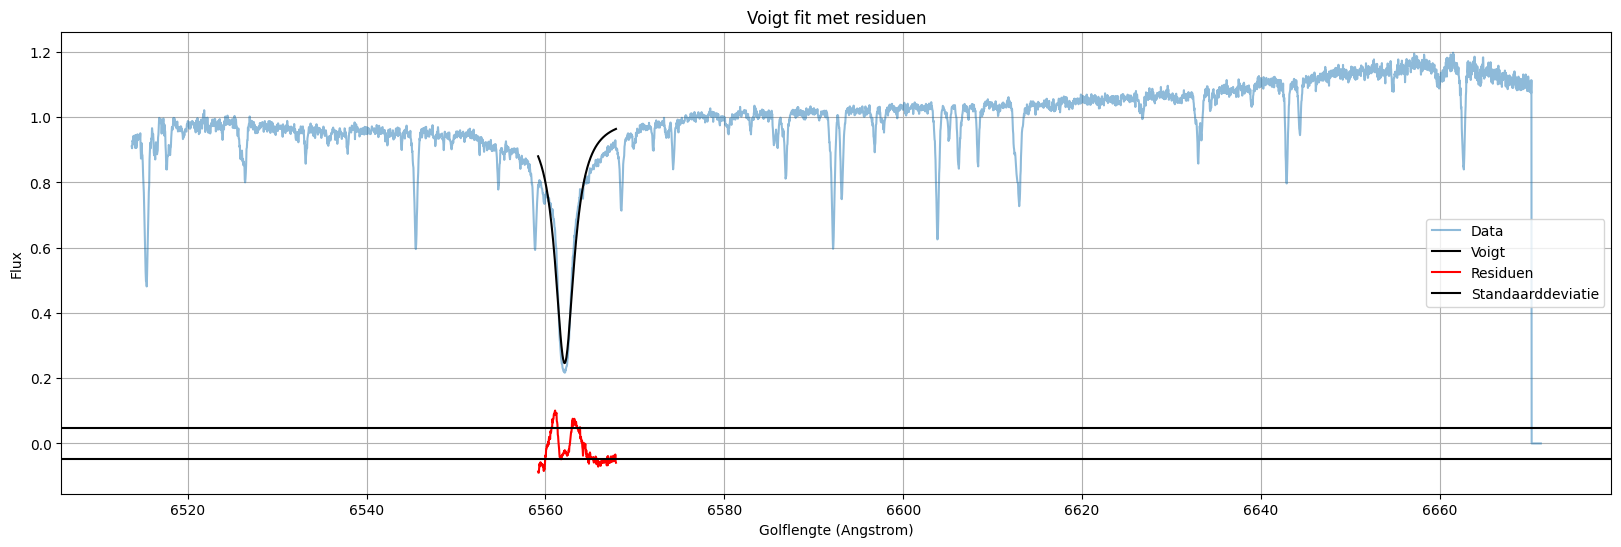

In [75]:
# Here you call the optimiser with the various inputs
# You may want to change:
#     * The range over which the function will fit the data, by slicing the x and y data arrays
#     * The starting / initial guess parameters p0
#     * The upper and lower bounds for each of the parameters that limit the optimiser
sliceb = 3198
slicee = 3434
popt, pcov =\
              curve_fit(
                  f = voigt,
                  xdata = wavelengths[sliceb:slicee],
                  ydata = Halpha_flux[sliceb:slicee],
                  p0 = [1.2, 6563, 1, 1],
                  bounds = ([1,  6550, 0, 0],
                            [5, 6576, 5, 5])
                  )

# Print the outputs.
print(f"popt = {popt}")
print(f"pcov = {pcov}")
# ==================
# `popt` is the array of best-fit parameters, but we can break it into individual variables:
scale_fit, x0_fit, alpha_fit, gamma_fit = popt
# To convert the covariance matrix into a similiar array of errors on the best-fit parameters,
# we take the square root of the diagonal of the covariance matrix using the following line
perr = np.sqrt(np.diag(pcov))
# And likewise break it into the individual parameters
dscale, dx0, dalpha, dgamma = perr

# Now we can print the paramters and errors. These lines use "f-strings", which  allow to specify
# variables and formatting, which are converted into strings and printed out
print(f"Best Fit Parameters: {scale_fit = :.3g}, {x0_fit = :.3g}, {alpha_fit = :.3g}, {gamma_fit = :.3g}")
print(f"Best Fit Errors: {dscale = :.3g}, {dx0 = :.3g}, {dalpha = :.3g}, {dgamma = :.3g}")


# Plot the fit
# ============
# Check that the fit is reasonable by overplotting it on the data
# Also plot the residuals (data - model). A 'good' fit should give residuals that are comparable in
# amplitude to the standard deviation noise in the data.
# You can also calculate the standard deviation of the residuals to compare directly, or plot the
# standard deviation levels as horizontal lines.

plt.figure(figsize=(20, 6))

#plt.plot(wavelengths, Halpha_flux)

f_G = 2 * alpha_fit
f_L = 2 * gamma_fit

f_V = f_L / 2 + np.sqrt(f_L**2 / 4 + f_G**2)
print(f"FWHM van de spectraallijn: {f_V:.3g}")

standard_deviation = np.std(ydata-voigt(xdata, *popt))

# Plot the fit
# ============
# Check that the fit is reasonable by overplotting it on the data
# Also plot the residuals (data - model). A 'good' fit should give residuals that are comparable in
# amplitude to the standard deviation noise in the data.
# You can also calculate the standard deviation of the residuals to compare directly, or plot the
# standard deviation levels as horizontal lines.

plt.figure(figsize=(20, 6))
plt.plot(wavelengths, Halpha_flux, label="Data", alpha=0.5)
plt.plot(xdata, voigt(xdata, *popt), label="Voigt", color='black')
plt.plot(xdata, ydata - voigt(xdata, *popt), label="Residuen", color='red')



#plt.figure(figsize=(20, 6))

#plt.plot(wavelengths, Halpha_flux, label="Data")

f_G = 2 * alpha_fit
f_L = 2 * gamma_fit

f_V = f_L / 2 + np.sqrt(f_L**2 / 4 + f_G**2)
print(f"FWHM van de spectraallijn: {f_V:.3g}")

#plt.plot(wavelengths[sliceb:slicee], voigt(wavelengths[sliceb:slicee], scale=scale_fit, x0=x0_fit, alpha=alpha_fit, gamma=gamma_fit), label="Voigt fit")

residuals = Halpha_flux[sliceb:slicee] - voigt(wavelengths[sliceb:slicee], *popt)
#plt.plot(wavelengths[sliceb:slicee], residuals, label="Residuen")

plt.axhline(y = -1 * standard_deviation, color="k")
plt.axhline(y = standard_deviation, color="k", label="Standaarddeviatie")

plt.legend()
plt.xlabel("Golflengte (Angstrom)")
plt.ylabel("Flux")
plt.title("Voigt fit met residuen")
plt.grid(True)

plt.savefig("Voigt_fit_met_residu")
plt.show()

x0_p = x0_fit
dx0_p = dx0

## Part 4: Measuring the Doppler velocity of the star

After fitting the line profile of Hydrogen-alpha, we can start to compute some information about the star itself, specifically its line-of-sight velocity. To do this, we will calculate its Doppler shift. Because the Earth is both rotating and orbiting the Sun at fairly high velocities, we also need to take these into account.

#### Importing Python packages

In [39]:
from astropy.time import Time
from astropy import units as u
from astropy.constants import c
from astropy.coordinates import SkyCoord, EarthLocation

## Radial velocity
The line centre wavelength can be used to measure the radial velocity of the star, also known as its 'Doppler shift'. To do this, use the usual Doppler shift equation:

$\Delta v = c \frac{\Delta \lambda}{\lambda_\mathrm{ref}}$, where $\Delta \lambda = \lambda_\mathrm{obs} - \lambda_\mathrm{ref}$.

$c$ is the speed of light, $\lambda_\mathrm{ref}$ is the rest-frame wavelength of H$\alpha$, and $\lambda_\mathrm{obs}$ is the wavelength of the line centre from your fit.

In additionm , you need to account for the motion of the Earth at the time of your observation as well. We correct the velocity to be with respect to the Sun. This is called the **heliocentric correction**

*   Compute the heliocentric correcton for the time and date of your observation
*   Use the Doppler formula to compute the measured radial velocity
*   Apply the heliocentric correction by adding it to your measurement
*   How does it agree with online astronomical databases (eg. Simbad)?

In [76]:
# First, we need the exact location of the observatory
Mercator = EarthLocation.from_geodetic(lat=28.762279*u.deg, lon=-17.878625*u.deg, height=2396*u.m)

# Give the coordinates of your object here. You provide two strings:
# RA (HH MM SS.SSS) and Dec (Deg Min Sec)
# You can give the reference frame for these coordinates as well. You can find that on Simbad (e.g. "ICRS")
sc = SkyCoord("17 52 38.7019050072", "-06 08 36.8880000", frame="icrs", unit=(u.hourangle, u.deg))

# Compute the barycentric correction - remember to update the time here for your observation
heliocorr = sc.radial_velocity_correction("heliocentric", obstime=Time("2024-04-20T04:14:11.435236", scale="utc"), location=Mercator)
rv = heliocorr.to(u.km/u.s).value

# Convert the measured line centre to a velocity
print(x0_p)
print(dx0_p)
lref    =    6562.8   # Rest frame wavelength of Halpha
c       =     299792.458  # Speed of light in km/s
Doppler =     c * (x0_p - lref)/lref  # Use the Doppler formula here
doppPlus = c * (x0_p + dx0_p - lref)/lref
doppMin = c * (x0_p - dx0_p - lref)/lref

# Correct the velocity and print the outputs
print("Heliocentric RV:","{:.2f}".format(Doppler + rv), "km/s")
print(f"[{doppMin}, {doppPlus}]")


6562.139266623424
0.016784028365593496
Heliocentric RV: -5.89 km/s
[-30.949382605785356, -29.415974572966327]
